In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [6]:
# Load Data and Preprocess
def load_data(filepath):
    # Load CSV (semicolon-separated)
    df = pd.read_csv(filepath, sep=';')
    
    # Label encode categorical columns
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    x = scaler.fit_transform(df)
    
    return df, x

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_
    return x_pca, explained_variance

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method) 
def find_optimal_clusters(x, max_clusters=10):
    inertia_values = []
    
    for k in range(1, max_clusters+1):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(x)
        inertia_values.append(km.inertia_)
    
    return inertia_values

# Perform KMeans Clustering 
def perform_kmeans_clustering(x, n_clusters=None):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(x)
    centroids = kmeans.cluster_centers_
    return labels, centroids


#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering 
def perform_agglomerative_clustering(x, n_clusters=None):
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglom.fit_predict(x)
    return labels


#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    linked = linkage(x, method='ward')
    return linked

# Plot Dendrogram
def plot_dendrogram(linked):
    plt.figure(figsize=(10, 6))
    dendrogram(linked)
    plt.title("Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()


## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

Data shape: (45211, 9)


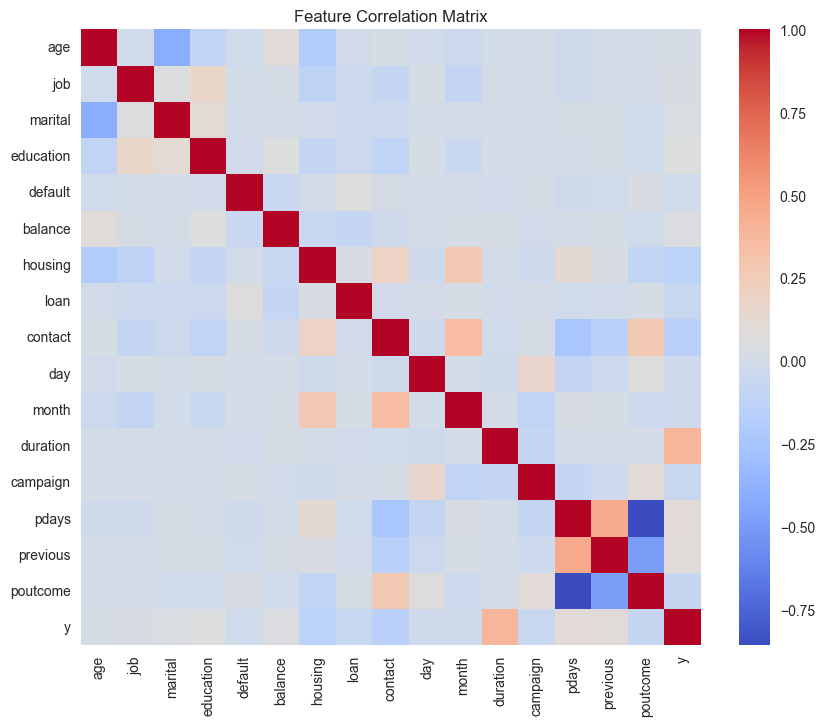

In [7]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.
    
    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Load data
    df = pd.read_csv(filepath, sep=';')
    
    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'poutcome', 'y']
    
    # Apply label encoding
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 
                'job', 'education', 'housing', 'loan', 'default']
    
    X = df[features]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


In [8]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement."""

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Randomly select n_clusters points from X as initial centroids."""
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        """Assign each sample to the nearest centroid."""
        # Compute distance of every point to every centroid → shape (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        
        # Assign cluster with minimum distance
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Update each centroid as the mean of all points assigned to it."""
        new_centroids = []
        
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]

            if len(cluster_points) == 0:
                # OPTIONAL: reinitialize empty cluster (simple strategy)
                new_centroids.append(self.centroids[k])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        
        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means clustering algorithm."""
        # Step 1: Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Step 2: Assign clusters
            labels = self._assign_clusters(X)

            # Step 3: Update centroids
            new_centroids = self._update_centroids(X, labels)

            # Step 4: Check convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-6):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

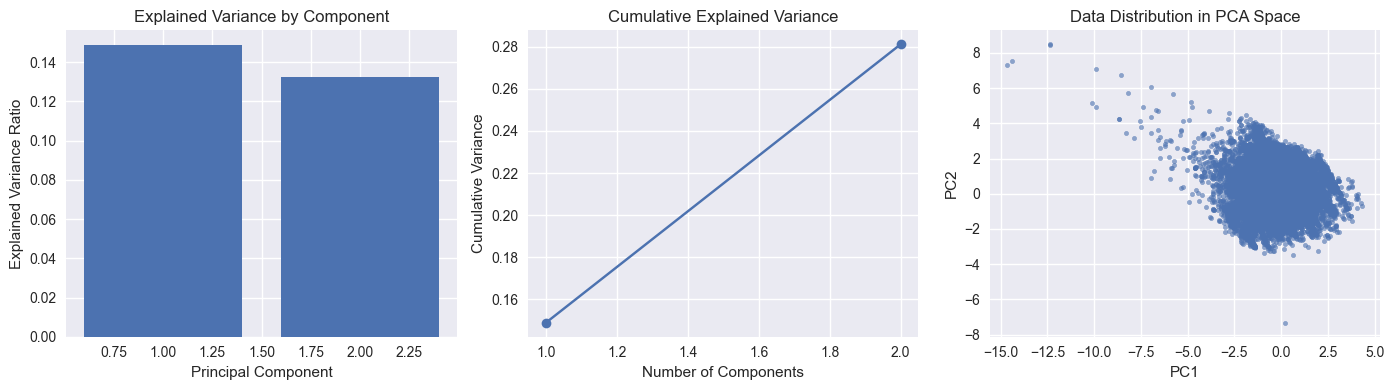

Shape after PCA: (45211, 2)


In [9]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.
    Generates visualizations:
    - Explained variance ratio
    - Cumulative explained variance
    - Data distribution in PCA 2D space
    """
    # 1. Initialize and fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    # ==================== VISUALIZATIONS ====================

    plt.figure(figsize=(14, 4))

    # ---- 1. Explained Variance Ratio ----
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), explained_var)
    plt.title("Explained Variance by Component")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")

    # ---- 2. Cumulative Variance ----
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components + 1), cumulative_var, marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")

    # ---- 3. PCA 2D Scatter Plot ----
    if n_components == 2:
        plt.subplot(1, 3, 3)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
        plt.title("Data Distribution in PCA Space")
        plt.xlabel("PC1")
        plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

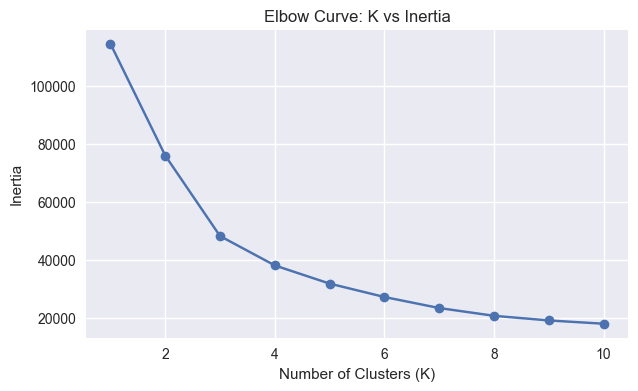

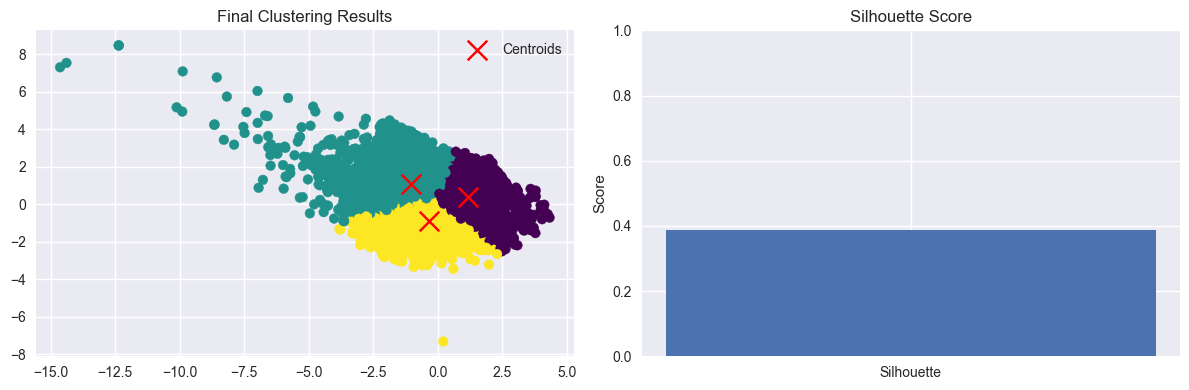

C:\Users\advai\AppData\Local\Temp\ipykernel_24536\2033294396.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette='viridis')


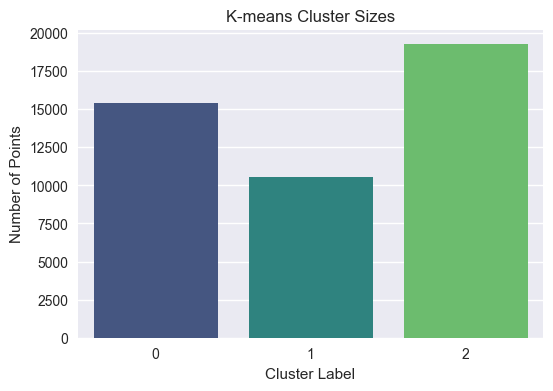

C:\Users\advai\AppData\Local\Temp\ipykernel_24536\2033294396.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sil_df, x='Cluster', y='Silhouette', palette='viridis')


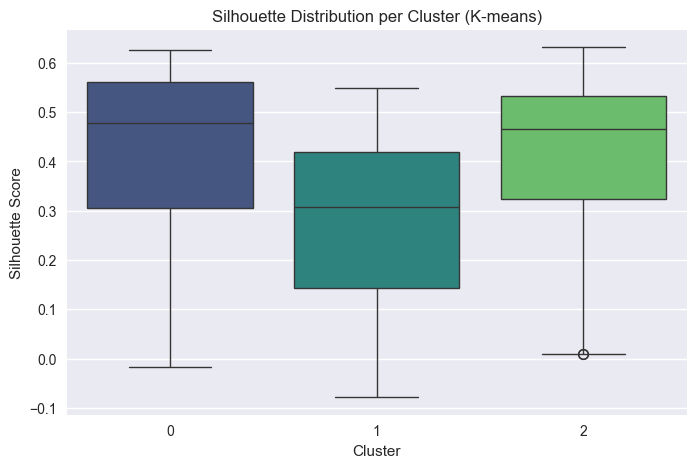


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [10]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0

    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[k])**2)

    return inertia

def plot_elbow_curve(X, max_k=10):
    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        kmeans = KMeansClustering(n_clusters=k)
        kmeans.fit(X)
        inertia = calculate_inertia(X, kmeans.labels, kmeans.centroids)
        inertias.append(inertia)

    # Plot elbow curve
    plt.figure(figsize=(7, 4))
    plt.plot(K, inertias, marker='o')
    plt.title("Elbow Curve: K vs Inertia")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    return inertias


# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

# Plot evaluation metrics
plt.subplot(1, 2, 2)
plt.bar(["Silhouette"], [silhouette])
plt.ylim(0, 1)
plt.title("Silhouette Score")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

# Count cluster sizes
unique_labels, counts = np.unique(kmeans.labels, return_counts=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=unique_labels, y=counts, palette='viridis')
plt.title("K-means Cluster Sizes")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points")
plt.show()

from sklearn.metrics import silhouette_samples

# Compute silhouette score per sample
sil_samples = silhouette_samples(X_pca, kmeans.labels)

# Prepare DataFrame for boxplot
sil_df = pd.DataFrame({
    'Silhouette': sil_samples,
    'Cluster': kmeans.labels
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=sil_df, x='Cluster', y='Silhouette', palette='viridis')
plt.title("Silhouette Distribution per Cluster (K-means)")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.show()

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [11]:
class BisectingKMeans:
    """Recursive Bisecting K-Means implementation (student version)."""

    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}
        self.centers_ = {}

    def fit_predict(self, X):
        n_samples = X.shape[0]

        # Start: all points in one cluster with label 0
        labels = np.zeros(n_samples, dtype=int)

        # This counter tracks which integer label to assign next
        next_label = 1

        # Continue splitting until we reach n_clusters
        while len(np.unique(labels)) < self.n_clusters:

            # ---- 1. Choose cluster to split: largest cluster ----
            unique, counts = np.unique(labels, return_counts=True)
            cluster_to_split = unique[np.argmax(counts)]

            # Extract points belonging to this cluster
            mask = (labels == cluster_to_split)
            X_subset = X[mask]

            # ---- 2. Perform binary K-means (k=2) ----
            km = KMeans(n_clusters=2, random_state=self.random_state, n_init='auto')
            sub_labels = km.fit_predict(X_subset)

            # Original cluster → two new clusters (left = 0, right = 1)
            left_label = cluster_to_split          # Keep original label
            right_label = next_label              # Assign brand new label
            next_label += 1

            # ---- 3. Update global labels ----
            # Points assigned to sublabel 0 keep original label
            labels[mask][sub_labels == 0] = left_label

            # Points assigned to sublabel 1 get a new label
            labels[mask][sub_labels == 1] = right_label

            # ---- 4. Save split info ----
            self.split_tree[cluster_to_split] = (left_label, right_label)
            self.centers_[left_label] = km.cluster_centers_[0]
            self.centers_[right_label] = km.cluster_centers_[1]

        # Save output
        self.labels_ = labels
        return labels


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!